29.11.2020

### Image Processing in Physics

#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

# Exercise 04: PSF and OTF

The goal of this exercise is to get familiar with the concepts of point spread
functions (PSF), optical transfer functions (OTF) and phase transfer functions
(PTF). You will create a Siemens star pattern and observe how the pattern
changes by applying a Gaussian and a pinhole blur.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

In [2]:
%matplotlib inline
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = None

**Task 1: Create the Siemens star pattern**

First of all, we need to create the Siemens star pattern. To avoid partial
volume effects, we generate this phantom with very high spatial resolution
first. The shape and number of line pairs are defined below.

In [3]:
sh_up = (2005, 2005)
ncycle = 60.

To create the pattern, we need to define Cartesian coordinates first.
Make sure that the origin of the coordinates is zero.

For instance, the x coordinates of an array with length 7 should be
[-3, -2, -1, 0, 1, 2, 3].

Remember the function `numpy.meshgrid` to make two two-dimensional arrays of pixel coordinates!

Text(0.5, 1.0, 'X')

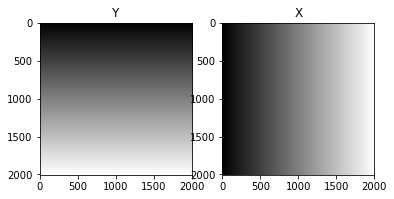

In [4]:
y_up = np.arange(-(sh_up[0] // 2), (sh_up[0] // 2) + 1)
x_up = np.arange(-(sh_up[1] // 2), (sh_up[1] // 2) + 1)
xx_up, yy_up = np.meshgrid(y_up, x_up)

plt.figure()
plt.subplot(121); plt.imshow(yy_up); plt.title("Y")
plt.subplot(122); plt.imshow(xx_up); plt.title("X")


As the test pattern is radially symmetric, we only need to **define the
angle of to the origin for every pixel**.

Have a look at the `numpy.arctan2` function to create an array which holds
the angle for every pixel.

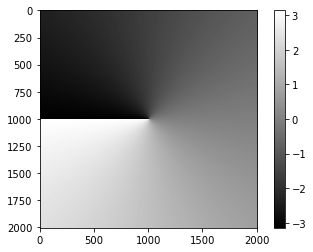

In [5]:
angles = np.arctan2(yy_up, xx_up)

plt.figure()
plt.imshow(angles); plt.colorbar()

We use this array to create the pattern,
by taking the modulo of 2 pi divided by the number of cycles.

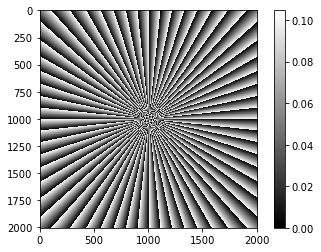

In [6]:
fields = angles % (2. * np.pi / ncycle)

plt.figure()
plt.imshow(fields); plt.colorbar()

Finally, **apply a threshold** to obtain a binary image.

Choose the threshold such that the cycles are evenly distributed.

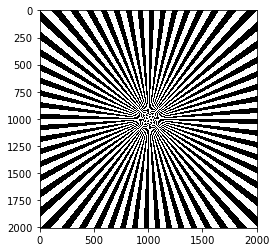

In [7]:
star_up = (fields > 0.05).astype(float)
plt.figure()
plt.imshow(star_up)

This binary image has sharp edges, which leads to so-called partial volume
effects, which are not desired.

To mitigate this effect, we **bin the image by a factor of 5**.

As seen in the last exercise, this can for instance be achieved,
by **reshaping the image and averaging over the according new dimensions**.

In [8]:
nbin = 5  # sh_up is a multiple of 5, so it works out!
star = star_up.reshape(sh_up[0] // nbin, nbin, sh_up[1] // nbin, nbin).mean((1, 3))

Now lets have a look at the original and sub-sampled pattern.

Observe how the sub-sampled image has smooth transitions at the edges!


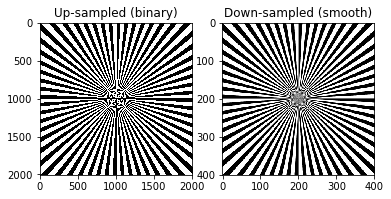

In [9]:
plt.figure()
plt.subplot(121)
plt.title('Up-sampled (binary)')
plt.imshow(star_up, interpolation='none', cmap='gray')
plt.subplot(122)
plt.title('Down-sampled (smooth)')
plt.imshow(star, interpolation='none', cmap='gray')

HINT: If you do not manage to create the star image, use the one provided in
the exercise folder.

To load the data just uncomment the following line:

In [10]:
# star = np.load('star.npy')

**Task 2: Convolution with Gaussian PSF**

Next we blur the (sub-sampled) star pattern by a Gaussian.
Therefore, we need to create a Gaussian kernel.
The shape of the Gaussian kernel should be `(25, 25)`,
which corresponds to a cutoff at $4 \sigma$.
This kernel corresponds to the point spread function of the system.

Hint: Create a small coordinate mesh with np.arange and np.meshgrid

In [11]:
sh = star.shape
sigma = 3

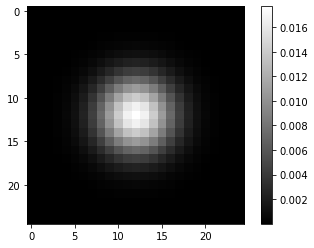

In [12]:
lw = 4 * sigma  # truncate at 4 sigma
x = np.arange(-lw, lw+1)
y = np.arange(-lw, lw+1)
xx, yy = np.meshgrid(y, x)
gauss =  np.exp(-(xx**2 + yy**2)/ (2 * sigma**2) )
gauss = gauss / gauss.sum()

plt.figure()
plt.imshow(gauss); plt.colorbar()

Convolve the test pattern with the kernel just created.

In [13]:
star_gauss = nd.convolve(star, gauss, mode='wrap')

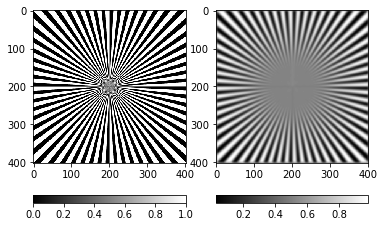

In [14]:
plt.figure()
plt.subplot(121)
plt.imshow(star); plt.colorbar(orientation="horizontal")
plt.subplot(122)
plt.imshow(star_gauss); plt.colorbar(orientation="horizontal")

To prepare the kernel for Fourier space analysis, make sure to
**match it to the dimensions of the Siemens pattern.**

Apply `np.fft.ifftshift` to the padded kernel!

In [15]:
gauss_padded = np.zeros(sh)
gauss_padded[sh[0]//2 - lw : sh[0]//2 + lw+1, sh[1]//2 - lw : sh[1]//2 + lw+1] = gauss
gauss_padded = np.fft.ifftshift(gauss_padded)

Calculate the OTF, which is simply the Fourier transform of the PSF. Also
extract the MTF and PTF accordingly.

In [16]:
gauss_otf = np.fft.fft2(gauss_padded)
gauss_mtf = np.abs(gauss_otf)
gauss_ptf = np.angle(gauss_otf)

Plot the results. What did you expect? How can the outer parts of the PTF be
explained?

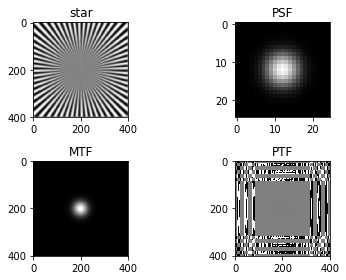

In [41]:
plt.figure()
plt.subplot(221)
plt.title('star')
plt.imshow(star_gauss)
plt.subplot(222)
plt.title('PSF')
plt.imshow(gauss)
plt.subplot(223)
plt.title('MTF')
plt.imshow(np.fft.fftshift(gauss_mtf))
plt.subplot(224)
plt.title('PTF')
plt.imshow(np.fft.fftshift(gauss_ptf))
plt.tight_layout()

**2b) BONUS TASK: Perform the convolution using the Convolution
theorem and check if the result is consistent with `star_gauss`**!

In [18]:
star_gauss_2 = np.fft.ifft2(np.fft.fft2(star) * gauss_otf).real

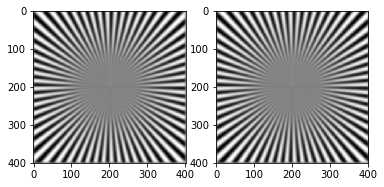

In [19]:
plt.figure()
plt.subplot(121); plt.imshow(star_gauss)
plt.subplot(122); plt.imshow(star_gauss_2)

**-- End bonus task--**

**Task 3: Convolution with Pinhole PSF**

Create a pinhole with a radius of 10. How small can the kernel be?

Make sure that the sum of kernel, or pinhole, is `1` and that the kernel is
of floating point type.


In [20]:
rad = 10
x = np.arange(-rad, rad+1)
y = np.arange(-rad, rad+1)
xx, yy = np.meshgrid(x, y)
pinhole = (xx**2 + yy**2) < rad**2
pinhole = pinhole.astype(np.float32)

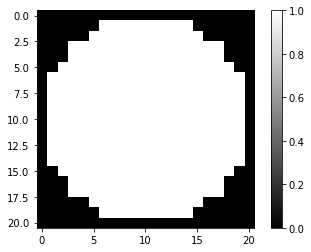

In [21]:
plt.figure()
plt.imshow(pinhole)
plt.colorbar()

**BONUS TASK: Smoother pinhole via upsampling**

To account for the partial volume effects, 
do the same thing, except using smaller steps than 1 for `x`, `y`
and then downsample via binning to get a smoother transition at the edges.

In [22]:
binning = 10
# use linspace here to get a symmetric kernel with odd sidelength!
x = np.linspace(-rad, rad, 21 * binning)
y = np.linspace(-rad, rad, 21 * binning)
xx, yy = np.meshgrid(x, y)
pinhole2 = np.sqrt(xx**2 + yy**2) < rad
pinhole2 = pinhole2.astype(np.float32)
ds_size = pinhole2.shape[0] // binning
pinhole2 = pinhole2.reshape(ds_size, binning, ds_size, binning).mean((1, 3))

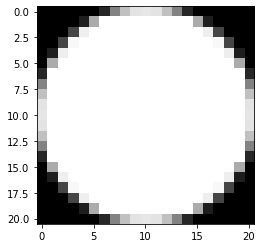

In [23]:
plt.figure()
plt.imshow(pinhole2)

If you performed the bonus task, overwrite the original pinhole with the smooth version.

In [24]:
pinhole2 = pinhole2 / pinhole2.sum()
pinhole = pinhole2

**-- End Bonus task --**

Convolve the test pattern with the pinhole.

In [25]:
pinhole.shape

(21, 21)

In [26]:
star_pinhole = nd.convolve(star, pinhole, mode="wrap")

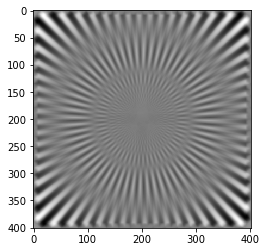

In [27]:
plt.figure()
plt.imshow(star_pinhole)

To prepare the PSF again for analysis in Fourier space,
make sure to match the dimensions to the star image.

In [28]:
pinhole_padded = np.zeros(sh)
pinhole_padded[sh[0]//2 - ds_size//2 : sh[0]//2 - ds_size//2 + ds_size, 
               sh[1]//2 - ds_size//2 : sh[1]//2 - ds_size//2 + ds_size] = pinhole
pinhole_padded = np.fft.ifftshift(pinhole_padded)

Calculate the OTF, MTF and PTF again.

In [29]:
pinhole_otf = np.fft.fft2(pinhole_padded)
pinhole_mtf = np.abs(pinhole_otf)
pinhole_ptf = np.angle(pinhole_otf)

Plot the results. What did you expect? Notice the shift in the color of the
cycles from light to dark if the phase wraps as illustrated by the PTF.


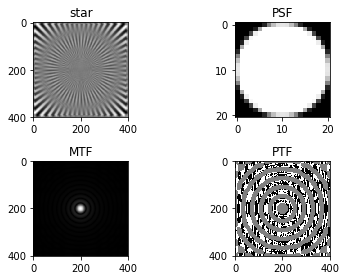

In [30]:
plt.figure()
plt.subplot(221)
plt.title('star')
plt.imshow(star_pinhole)
plt.subplot(222)
plt.title('PSF')
plt.imshow(pinhole)
plt.subplot(223)
plt.title('MTF')
plt.imshow(np.fft.fftshift(pinhole_mtf))
plt.subplot(224)
plt.title('PTF')
plt.imshow(np.fft.fftshift(pinhole_ptf))
plt.tight_layout()

**Task 4: Naive Deconvolution**

We now want to recover from `star_pinhole` (the image that we have measured)
the underlying image (star).
Knowing the OTF of our system, we can perform a simple
Fourier space deconvolution.
A convolution in real space is an element wise multiplication in
Fourier space.

However, a deconvolution is just an element wise division of the kernel
in Fourier space.
Recover the underlying image by applying this "naive" deconvolution only using 
'star_pinhole' and 'pinhole_otf'.

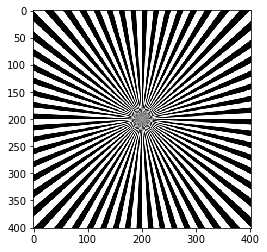

In [31]:
star_ft = np.fft.fft2(star_pinhole)
star_pinhole_deconvolved = np.fft.ifft2(star_ft / pinhole_otf).real

plt.figure()
plt.imshow(star_pinhole_deconvolved)

However, this fails in the presence of noise, which is almost always the case
for actual measurements. Add a tiny amount of Gaussian noise with a sigma of
only `1e-3` to `star_pinhole` and perform the naive deconvolution again.

In [32]:
noise = np.random.normal(0, 1e-3, sh)
star_pinhole_noise = star_pinhole + noise
star_pinhole_noise_deconvolved = np.fft.ifft2(np.fft.fft2(star_pinhole_noise) / pinhole_otf).real

Plot the results. Can you see the noise in the third image? This however is
enough to make the naive deconvolution approach useless.

Hint: If you don't see a difference, make sure your pinhole kernel is normalized so that star_pinhole $\in [0, 1]$.

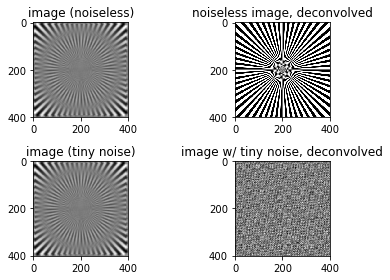

In [33]:
plt.figure()
plt.subplot(221)
plt.title('image (noiseless)')
plt.imshow(star_pinhole)
plt.subplot(222)
plt.title('noiseless image, deconvolved')
plt.imshow(star_pinhole_deconvolved)
plt.subplot(223)
plt.title('image (tiny noise)')
plt.imshow(star_pinhole_noise)
plt.subplot(224)
plt.title('image w/ tiny noise, deconvolved')
plt.imshow(star_pinhole_noise_deconvolved)
plt.tight_layout()

**Task 5: Wiener Deconvolution**

The Wiener filter is a smarter method of performing deconvolution.
It is derived by assuming the input image is the result of a convolution with a point-spread function $\Pi$, plus some noise:

$$y(\vec{r}) = \Pi(\vec{r}) \otimes x(\vec{r}) + n(\vec{r})$$

In the Fourier domain, this becomes:

$$Y(\vec{f}) = OTF(\vec{f}) \cdot X(\vec{f}) + N(\vec{f})$$

The Wiener filter $G$ is a frequency filter applied to the input data ($Y$) such that
the error with respect relative to the true image $X$

$$\varepsilon(\vec{f}) = E \left[ \left| G(\vec{f}) \cdot Y(\vec{f}) - X(\vec{f}) \right|^2 \right]$$

is minimized. This turns out the be:

$$ G(\vec{f}) = \frac{1}{OTF(\vec{f})} \frac{|OTF(\vec{f})|^2}{|OTF(\vec{f})|^2 + \langle |N(\vec{f})|^2 \rangle / \langle |X(\vec{f})|^2 \rangle}$$.

We can approximate $\langle |X(\vec{f})|^2 \rangle$ with $\langle |Y(\vec{f})|^2 \rangle$ and e.g. assume a constant value $N$ for $\langle |N(\vec{f})|^2 \rangle$ (which is accurate if we have white noise):

$$ G(\vec{f}) = \frac{1}{OTF(\vec{f})} \frac{|OTF(\vec{f})|^2}{|OTF(\vec{f})|^2 + N \, / \, \langle |Y(\vec{f})|^2 \rangle}$$.


Let's thus define the Wiener deconvolution in a separate function:

In [34]:
def wiener_deconv(img, psf, nps):
    """
    This function performs an image deconvolution using a Wiener filter.

    Parameters
    ----------
    img : ndarray
      convolved image
    psf : ndarray
      the convolution kernel
    nps : float or ndarray
      noise power spectrum of the image, you will have to choose an
      appropriate value

    Returns
    -------
    deconvolved_image : ndarray
      The deconvolved image or volume depending on the input image.

    Notes
    -----
    If a float is given as nps, it assumes intrinsically white noise.
    A nps of 0 corresponds to no noise, and therefore naive image
    deconvolution.
    """
    # Apart from the noise power spectrum (nps), which is passed as a
    # parameter, you'll also need the frequency representation of your psf,
    # the power spectrum of the filter and the signal power spectrum (sps).
    # Calculate them.

    H = np.fft.fft2(psf)
    G = np.fft.fft2(img)

    # create the Wiener filter
    wiener_filter = 1 / H * (np.abs(H)**2 / (np.abs(H)**2 + nps / np.abs(G)**2))

    # Do a Fourier space convolution of the image with the wiener filter
    deconv_img = np.real(np.fft.ifft2(G * wiener_filter))

    return deconv_img

Let's apply the filter to the noisy version of the pinhole-blurred
noisy image of the Siemens star.

As a second argument, `wiener_deconv` takes the point-spread function of the system.

In [35]:
nps = 1e-3**2
star_pinhole_wiener = wiener_deconv(star_pinhole_noise, pinhole_padded, nps)

Let's compare the result with the one from naive deconvolution:

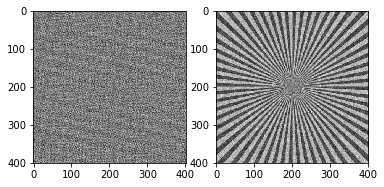

In [36]:
plt.figure()
plt.subplot(121)
plt.imshow(star_pinhole_noise_deconvolved)
plt.subplot(122)
plt.imshow(star_pinhole_wiener)